# Regression with keras
## Normalization of features, linear regression, DNN regression
### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## Load data

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
369,34.0,4,112.0,88.0,2395.0,18.0,82,1
271,23.2,4,156.0,105.0,2745.0,16.7,78,1
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
92,13.0,8,351.0,158.0,4363.0,13.0,73,1
385,38.0,4,91.0,67.0,1995.0,16.2,82,3


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [6]:
# remove na
dataset = dataset.dropna()

In [7]:
# encode Origin
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
152,19.0,6,225.0,95.0,3264.0,16.0,75,0,0,1
95,12.0,8,455.0,225.0,4951.0,11.0,73,0,0,1
121,15.0,8,318.0,150.0,3399.0,11.0,73,0,0,1
23,26.0,4,121.0,113.0,2234.0,12.5,70,1,0,0
179,22.0,4,121.0,98.0,2945.0,14.5,75,1,0,0


## Split data

In [8]:
train_dataset = dataset.sample(frac = 0.8, random_state = 42)
test_dataset = dataset.drop(train_dataset.index)

## Quick EDA

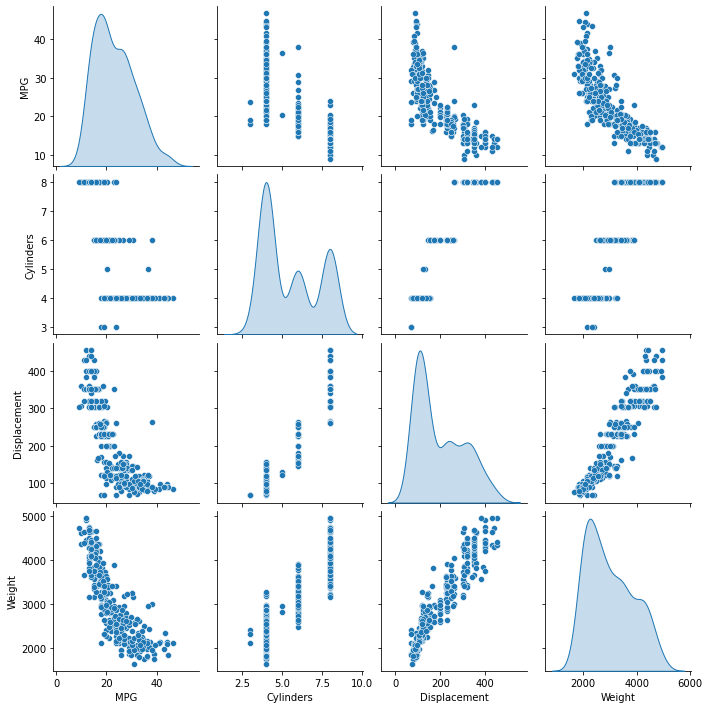

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind = 'kde')

In [10]:
train_dataset.describe().iloc[1:3]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
mean,23.153822,5.531847,197.855096,105.971338,3005.745223,15.510828,75.910828,0.171975,0.203822,0.624204
std,7.861854,1.729449,106.501896,39.636557,859.060925,2.803560,3.688989,0.377961,0.403481,0.485101


In [11]:
# obtain features and labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Utilities

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [13]:
# istantiate and adapt the normalization layer
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_features))

## Models

### Linear regression

In [14]:
# build model
linear_model = tf.keras.Sequential([normalizer, layers.Dense(1)])

In [15]:
# compile model
linear_model.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
                     metrics = [tf.keras.metrics.MeanSquaredError()])

In [16]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [17]:
%%time
history_linear = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 77ms/step - loss: 23.1055 - mean_squared_error: 578.6573 - val_loss: 21.7696 - val_mean_squared_error: 505.0828
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 22.1525 - mean_squared_error: 522.0073 - val_loss: 21.1135 - val_mean_squared_error: 471.5039
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 21.3213 - mean_squared_error: 479.4591 - val_loss: 20.6354 - val_mean_squared_error: 442.5554
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 20.4386 - mean_squared_error: 435.3611 - val_loss: 20.1029 - val_mean_squared_error: 417.5245
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 19.5684 - mean_squared_error: 399.4720 - val_loss: 19.5018 - val_mean_squared_error: 393.3737
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 18.7351 - mean_squared_error: 369.3011 - val_loss: 18.9462 - val_mean_squared_error: 374.4943
Epoch 

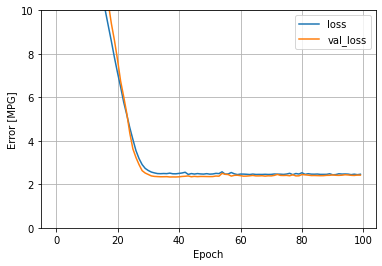

In [18]:
plot_loss(history_linear)

In [19]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

### DNN model

In [20]:
# build the net
dnn_model = keras.Sequential([
                              normalizer,
                              layers.Dense(64, activation = 'relu'),
                              layers.Dense(32, activation = 'relu'),
                              layers.Dense(16, activation = 'relu'),
                              layers.Dense(1),
])

# compile the net
dnn_model.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
                  metrics = [tf.keras.metrics.MeanSquaredError()])

# visualize the net
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,284
Trainable params: 3,265
Non-trainable params: 19
___________________________________________________

In [21]:
%%time
history_dnn = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 23.6365 - mean_squared_error: 623.6537 - val_loss: 22.1410 - val_mean_squared_error: 553.8291
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 23.3770 - mean_squared_error: 610.6602 - val_loss: 21.9149 - val_mean_squared_error: 543.0352
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 23.1212 - mean_squared_error: 597.7092 - val_loss: 21.6922 - val_mean_squared_error: 532.6035
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 22.8654 - mean_squared_error: 584.9790 - val_loss: 21.4441 - val_mean_squared_error: 521.3219
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 22.5858 - mean_squared_error: 571.7097 - val_loss: 21.1536 - val_mean_squared_error: 508.6609
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 22.2493 - mean_squared_error: 556.2548 - val_loss: 20.7895 - val_mean_squared_error: 493.4772
Epoch 7/1

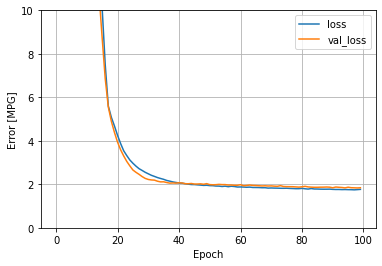

In [22]:
plot_loss(history_dnn)

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [23]:
# save and reload the model (DOESN'T WORK-> bug with Normalization)
#dnn_model.save('dnn_model.h5')
#reloaded = tf.keras.models.load_model('dnn_model.h5')

#test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=0)

In [24]:
pd.DataFrame(test_results, index=['mae','mse']).T

,mae,mse
linear_model,2.492087,9.825180
dnn_model,1.901490,7.101861
